In [1]:
%reset

import numpy as np
from sklearn import preprocessing
import math
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import pandas as pd
from numpy import *


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D, Masking


from sklearn import preprocessing, neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report

import seaborn as sns
from pylab import rcParams

from numpy.linalg import *
import math
from datetime import datetime
from datetime import timedelta


import tensorflow as tf
from tensorflow import keras
import os
import keras


os.environ["CUDA_VISIBLE_DEVICES"]='1'

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
# do stuff


%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Using TensorFlow backend.
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/jupyterhub/anaconda/lib/python3.6/site-packag

In [2]:
# Import the data and making a dataframe out of it
df_deli = pd.read_csv('../Emilio Caba/Data/Delivery.csv')
df_cons = pd.read_csv('../Emilio Caba/Data/Consumption.csv')
df_info = pd.read_csv('../Emilio Caba/Data/Information.csv')
df_weather = pd.read_csv('../Data/KNMI_Voorschoten_20170711_20190601.csv')

# Setting indexes
df_deli.set_index('ID-nummer',inplace=True)
df_deli.index = pd.to_datetime(df_deli.index)
df_deli.index.names = ['date']

df_cons.set_index('ID-nummer',inplace=True)
df_cons.index = pd.to_datetime(df_cons.index)
df_cons.index.names = ['date']

df_info.set_index('ID-nummer',inplace=True)
df_info.index.names = ['date']

df_weather.set_index('Date_and_time',inplace=True)
df_weather = df_weather.loc['2017-09-12':'2019-06-01 00:00:00']
df_weather.index = pd.to_datetime(df_weather.index)
df_weather.index.names = ['date']
df_weather = df_weather.apply(pd.to_numeric)

# Creating first row to datasets
top_row = [0 for col in df_deli.columns]
df_top_row = pd.DataFrame(top_row).transpose()

s_top_row = pd.Series([pd.to_datetime('2017-09-12 00:00:00')])
df_top_row.set_index(s_top_row, inplace=True)
df_top_row.columns = df_deli.columns

# Adding first row to the datasets
df_deli = pd.concat([df_top_row, df_deli])
df_cons = pd.concat([df_top_row, df_cons])

# Joining datasets
df_deli = df_deli.join(df_weather)
df_cons = df_cons.join(df_weather)

# Filling NaN temperature values with the previous ones
df_deli.fillna(method='ffill', inplace=True)
df_cons.fillna(method='ffill', inplace=True)

# Deleting first row (dummy row)
df_deli = df_deli.iloc[1:]
df_cons = df_cons.iloc[1:]

display(df_deli.head(2))
display(df_deli.shape)
display(df_cons.head(2))
display(df_cons.shape)

,H01,H02,H03,H04,H06,H07,H08,H09,H11,H13,...,H27,H28,H29,H31,H32,H33,T,SQ,Q,N
2017-09-12 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,14.8,0.0,0.0,7.0
2017-09-12 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,14.8,0.0,0.0,7.0


(54745, 32)

,H01,H02,H03,H04,H06,H07,H08,H09,H11,H13,...,H27,H28,H29,H31,H32,H33,T,SQ,Q,N
2017-09-12 00:15:00,0.031,0.048,0.027,0.017,0.074,0.012,0.023,0.055,0.075,0.131,...,0.096,0.025,0.024,0.299,0.027,0.022,14.8,0.0,0.0,7.0
2017-09-12 00:30:00,0.037,0.023,0.034,0.015,0.069,0.024,0.020,0.036,0.071,0.088,...,0.152,0.018,0.028,0.325,0.021,0.042,14.8,0.0,0.0,7.0


(54745, 32)

In [3]:
from datetime import date, datetime

def get_season(year_day):
    spring = range(80, 172) # Corresponds to season 1
    summer = range(172, 264) # Corresponds to season 2
    fall = range(264, 355) # Corresponds to season 3
    # winter Corresponds to season 4

    if year_day in spring:
        season = 1
    elif year_day in summer:
        season = 2
    elif year_day in fall:
        season = 3
    else:
        season = 4
    return season

In [4]:
df_deli = df_deli[['H01','H02','H06','H07','H08','H15','H16','H17','H18','H23','H20','H22','H25','H28','H32','T','SQ','Q','N']]
df_cons = df_cons[['H01','H02','H06','H07','H08','H15','H16','H17','H18','H23','H20','H22','H25','H28','H32','T','SQ','Q','N']]
df_info = df_info[['H01','H02','H06','H07','H08','H15','H16','H17','H18','H23','H20','H22','H25','H28','H32']]

display(df_deli)
display(df_cons)
display(df_info)

,H01,H02,H06,H07,H08,H15,H16,H17,H18,H23,H20,H22,H25,H28,H32,T,SQ,Q,N
2017-09-12 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.8,0.0,0.0,7.0
2017-09-12 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.8,0.0,0.0,7.0
2017-09-12 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.8,0.0,0.0,7.0
2017-09-12 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.6,0.0,0.0,6.0
2017-09-12 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.6,0.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-31 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.5,0.0,0.0,8.0
2019-05-31 23:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.5,0.0,0.0,8.0
2019-05-31 23:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.5,0.0,0.0,8.0
2019-05-31 23:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.5,0.0,0.0,8.0


,H01,H02,H06,H07,H08,H15,H16,H17,H18,H23,H20,H22,H25,H28,H32,T,SQ,Q,N
2017-09-12 00:15:00,0.031,0.048,0.074,0.012,0.023,0.033,0.396,0.122,0.069,0.044,0.029,0.038,0.021,0.025,0.027,14.8,0.0,0.0,7.0
2017-09-12 00:30:00,0.037,0.023,0.069,0.024,0.020,0.033,0.331,0.053,0.059,0.033,0.017,0.034,0.025,0.018,0.021,14.8,0.0,0.0,7.0
2017-09-12 00:45:00,0.034,0.017,0.073,0.020,0.011,0.028,0.062,0.048,0.071,0.038,0.016,0.019,0.025,0.022,0.029,14.8,0.0,0.0,7.0
2017-09-12 01:00:00,0.296,0.023,0.066,0.019,0.012,0.028,0.053,0.052,0.546,0.038,0.023,0.015,0.025,0.019,0.029,14.6,0.0,0.0,6.0
2017-09-12 01:15:00,0.311,0.018,0.059,0.012,0.016,0.193,0.069,0.168,0.057,0.207,0.023,0.033,0.024,0.021,0.022,14.6,0.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-31 23:00:00,0.696,0.052,0.020,0.051,0.064,0.073,0.071,0.055,0.078,0.080,0.027,0.265,0.023,0.021,0.044,12.5,0.0,0.0,8.0
2019-05-31 23:15:00,0.232,0.057,0.019,0.040,0.056,0.069,0.210,0.051,0.123,0.085,0.024,0.177,0.022,0.026,0.049,12.5,0.0,0.0,8.0
2019-05-31 23:30:00,0.020,0.065,0.019,0.029,0.027,0.082,0.313,0.055,0.317,0.093,0.023,0.031,0.022,0.025,0.037,12.5,0.0,0.0,8.0
2019-05-31 23:45:00,0.029,0.056,0.026,0.030,0.014,0.092,0.364,0.039,0.331,0.103,0.033,0.047,0.017,0.034,0.022,12.5,0.0,0.0,8.0


,H01,H02,H06,H07,H08,H15,H16,H17,H18,H23,H20,H22,H25,H28,H32
date,,,,,,,,,,,,,,,
concept,E,E,E,E,E,WP,WP,WP,WP,WP,Zon,Zon,Zon,Zon,Zon
PV-aantal,17,14,14,13,9,9,11,8,11,11,10,12,13,13,12
personen,4,2,4,2,4,1,4,4,4,2,2,4,2,2,4


In [5]:
# Setting dummy variables

df_deli['season'] = [get_season(index.timetuple().tm_yday) for index in df_deli.index]
df_cons['season'] = [get_season(index.timetuple().tm_yday) for index in df_cons.index]

df_deli['month'] = df_deli.index.month
df_cons['month'] = df_cons.index.month

df_deli['week'] = df_deli.index.week
df_cons['week'] = df_cons.index.week

df_deli['day'] = df_deli.index.day
df_cons['day'] = df_cons.index.day

df_deli['hour'] = df_deli.index.hour
df_cons['hour'] = df_cons.index.hour




df_deli['hour'].unique()


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [6]:
'''
df_deli = df_deli.groupby([df_deli.index.year, df_deli.index.month, df_deli.index.week,df_cons.index.hour]).agg({'H01':'sum',
                                                   'H02':'sum',
                                                   #'H03':'sum',
                                                   #'H04':'sum',
                                                   'H06':'sum',
                                                   'H07':'sum',
                                                   'H08':'sum',
                                                   #'H09':'sum',
                                                   #'H11':'sum',
                                                   #'H13':'sum',
                                                   'H15':'sum',
                                                   'H16':'sum',
                                                   'H17':'sum',
                                                   'H18':'sum',
                                                   #'H19':'sum',
                                                   'H20':'sum',
                                                   #'H21':'sum',
                                                   'H22':'sum',
                                                   'H23':'sum',
                                                   #'H24':'sum',
                                                   'H25':'sum',
                                                   #'H26':'sum',
                                                   #'H27':'sum',
                                                   'H28':'sum',
                                                   #'H29':'sum',
                                                   #'H31':'sum',
                                                   'H32':'sum',
                                                   #'H33':'sum',
                                                   'T':'mean',
                                                   'SQ':'mean',
                                                   'Q':'mean',
                                                   'N':'mean',
                                                   'week':'median',
                                                   'month':'median',
                                                   'season':'median',
                                                    'day' : 'median',
                                                    'hour' : 'median'
                                                  })


df_cons = df_cons.groupby([df_cons.index.year, df_cons.index.month, df_cons.index.week,df_cons.index.hour]).agg({'H01':'sum',
                                                   'H02':'sum',
                                                   #'H03':'sum',
                                                   #'H04':'sum',
                                                   'H06':'sum',
                                                   'H07':'sum',
                                                   'H08':'sum',
                                                   #'H09':'sum',
                                                   #'H11':'sum',
                                                   #'H13':'sum',
                                                   'H15':'sum',
                                                   'H16':'sum',
                                                   'H17':'sum',
                                                   'H18':'sum',
                                                   #'H19':'sum',
                                                   'H20':'sum',
                                                   #'H21':'sum',
                                                   'H22':'sum',
                                                   'H23':'sum',
                                                   #'H24':'sum',
                                                   'H25':'sum',
                                                   #'H26':'sum',
                                                   #'H27':'sum',
                                                   'H28':'sum',
                                                   #'H29':'sum',
                                                   #'H31':'sum',
                                                   'H32':'sum',
                                                   #'H33':'sum',
                                                   'T':'mean',
                                                   'SQ':'mean',
                                                   'Q':'mean',
                                                   'N':'mean',
                                                   'week':'median',
                                                   'month':'median',
                                                   'season':'median',
                                                     'day' : 'median',
                                                    'hour' : 'median'
                                                  })
                                                  
'''

"\ndf_deli = df_deli.groupby([df_deli.index.year, df_deli.index.month, df_deli.index.week,df_cons.index.hour]).agg({'H01':'sum',\n                                                   'H02':'sum',\n                                                   #'H03':'sum',\n                                                   #'H04':'sum',\n                                                   'H06':'sum',\n                                                   'H07':'sum',\n                                                   'H08':'sum',\n                                                   #'H09':'sum',\n                                                   #'H11':'sum',\n                                                   #'H13':'sum',\n                                                   'H15':'sum',\n                                                   'H16':'sum',\n                                                   'H17':'sum',\n                                                   'H18':'sum',\n                    

In [7]:
# Setting different columns (delivery, consumption, houses_info, dummy_variables)
df = pd.DataFrame(columns=['delivery','consumption', 'T', 'SQ', 'Q', 'N','heating_sys','week','month','season','day','hour'])

num_houses_cols = 15
#num_houses_cols = 28
# Preparing the delivery and consumption arrays
ar_deli = np.array([])
ar_cons = np.array([])
for col in range(num_houses_cols):
    ar_deli = np.append(ar_deli, df_deli.values[:, col])
    ar_cons = np.append(ar_cons, df_cons.values[:, col])

# Preparing the houses information arrays
ar_heatSystem = np.array([])
for col in df_info.columns:
    ar_heatSystem = np.append(ar_heatSystem, (df_info.loc[['concept'], [col]].values[0].tolist() * df_deli.shape[0]))

# Inserting the data to the dataframe
df['delivery'] = pd.Series(ar_deli)
df['consumption'] = pd.Series(ar_cons)

df['T'] = df_deli['T'].values.tolist() * num_houses_cols
df['SQ'] = df_deli['SQ'].values.tolist() * num_houses_cols
df['Q'] = df_deli['Q'].values.tolist() * num_houses_cols
df['N'] = df_deli['N'].values.tolist() * num_houses_cols

df['month'] = df_deli['month'].values.tolist() * num_houses_cols
df['week'] = df_deli['week'].values.tolist() * num_houses_cols
df['season'] = df_deli['season'].values.tolist() * num_houses_cols
df['day'] = df_deli['day'].values.tolist() * num_houses_cols
df['hour'] = df_deli['hour'].values.tolist() * num_houses_cols

df['heating_sys'] = pd.Series(ar_heatSystem)

# Replacing heating system type by numbers
df.replace('E', 1, inplace=True)
df.replace('WP', 2, inplace=True)
df.replace('Zon', 3, inplace=True)

display(df.head())
display(df.shape)

,delivery,consumption,T,SQ,Q,N,heating_sys,week,month,season,day,hour
0,0.0,0.031,14.8,0.0,0.0,7.0,1,37,9,2,12,0
1,0.0,0.037,14.8,0.0,0.0,7.0,1,37,9,2,12,0
2,0.0,0.034,14.8,0.0,0.0,7.0,1,37,9,2,12,0
3,0.0,0.296,14.6,0.0,0.0,6.0,1,37,9,2,12,1
4,0.0,0.311,14.6,0.0,0.0,6.0,1,37,9,2,12,1


(821175, 12)

In [8]:
#method to shuffle the dataframe/ n=100 parameter return a shuffle dataframe with lenght 100

#df = df.sample(frac=1) #n=3/frac=1

#with 1000 samples we got 94% and with one lstm layer and lr 0.01

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 821175 entries, 0 to 821174
Data columns (total 12 columns):
delivery       821175 non-null float64
consumption    821175 non-null float64
T              821175 non-null float64
SQ             821175 non-null float64
Q              821175 non-null float64
N              821175 non-null float64
heating_sys    821175 non-null int64
week           821175 non-null int64
month          821175 non-null int64
season         821175 non-null int64
day            821175 non-null int64
hour           821175 non-null int64
dtypes: float64(6), int64(6)
memory usage: 75.2 MB


In [10]:
#df = df[(df[['delivery']] == 0.0).any(1)] #deletting the rows of 0 delivery
#df = df[(df[['consumption']] == 0.0).any(1)] #deletting the rows of 0 delivery

del_heat = df[['delivery','consumption','T','SQ','Q','week','month','season','day','hour']] #storing only the columns that i want to use to train, (all of them except the target variable)
del_heat.head()


,delivery,consumption,T,SQ,Q,week,month,season,day,hour
0,0.0,0.031,14.8,0.0,0.0,37,9,2,12,0
1,0.0,0.037,14.8,0.0,0.0,37,9,2,12,0
2,0.0,0.034,14.8,0.0,0.0,37,9,2,12,0
3,0.0,0.296,14.6,0.0,0.0,37,9,2,12,1
4,0.0,0.311,14.6,0.0,0.0,37,9,2,12,1


In [11]:
#del_heat['N'] = pd.to_numeric(del_heat['N']) #converting to numeric, it was an object
#del_heat['PV-aantal'] = pd.to_numeric(del_heat['PV-aantal']) #converting to numeric, it was an object


del_heat['day'] = del_heat['day'].astype(int)
del_heat['hour'] = del_heat['hour'].astype(int)

display(del_heat.max()) #checking if it works well

display(del_heat.head())

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


delivery         0.911
consumption      2.606
T               34.200
SQ              10.000
Q              335.000
week            52.000
month           12.000
season           4.000
day             31.000
hour            23.000
dtype: float64

,delivery,consumption,T,SQ,Q,week,month,season,day,hour
0,0.0,0.031,14.8,0.0,0.0,37,9,2,12,0
1,0.0,0.037,14.8,0.0,0.0,37,9,2,12,0
2,0.0,0.034,14.8,0.0,0.0,37,9,2,12,0
3,0.0,0.296,14.6,0.0,0.0,37,9,2,12,1
4,0.0,0.311,14.6,0.0,0.0,37,9,2,12,1


In [12]:
x = del_heat.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_norm = pd.DataFrame(x_scaled)

df_norm

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.011896,0.543529,0.0,0.0,0.705882,0.727273,0.333333,0.366667,0.000000
1,0.0,0.014198,0.543529,0.0,0.0,0.705882,0.727273,0.333333,0.366667,0.000000
2,0.0,0.013047,0.543529,0.0,0.0,0.705882,0.727273,0.333333,0.366667,0.000000
3,0.0,0.113584,0.538824,0.0,0.0,0.705882,0.727273,0.333333,0.366667,0.043478
4,0.0,0.119340,0.538824,0.0,0.0,0.705882,0.727273,0.333333,0.366667,0.043478
...,...,...,...,...,...,...,...,...,...,...
821170,0.0,0.016884,0.489412,0.0,0.0,0.411765,0.363636,0.000000,1.000000,1.000000
821171,0.0,0.018803,0.489412,0.0,0.0,0.411765,0.363636,0.000000,1.000000,1.000000
821172,0.0,0.014198,0.489412,0.0,0.0,0.411765,0.363636,0.000000,1.000000,1.000000
821173,0.0,0.008442,0.489412,0.0,0.0,0.411765,0.363636,0.000000,1.000000,1.000000


In [13]:
#df_arr = df_norm.values
#a2 = df_arr.reshape(15,54745,10) #15 houses #54745rows per house #10features per house 
#a2


df_arr = df_norm.values
a2 = df_arr.reshape(15,54745,10) #15 houses #54745rows per house #10features per house 
a2.shape



(15, 54745, 10)

In [14]:
total = df_norm.values #array converting from the normalized dataframe 

#output = df['heating_sys'] #storing the target variable column

 

#output_norm = (output-np.min(output))/(np.max(output)-np.min(output)) #target variable normalitation
#output_norm.unique()


In [15]:
labeled_out = np.zeros((df['heating_sys'].shape[0], 3))

for i in range(len(df['heating_sys'])):
    if df['heating_sys'][i] == 1:
        labeled_out[i] = [1,0,0]
    elif df['heating_sys'][i] == 2:
        labeled_out[i] = [0,1,0]
    else:
        labeled_out[i] = [0,0,1]
        
labeled_out.shape



(821175, 3)

In [16]:

X_train, X_test, Y_train, Y_test = train_test_split(total,labeled_out, test_size=0.3) #splitin the 30% of the data to test


#X_train, X_test, Y_train, Y_test = train_test_split(a2,labeled_out, test_size=0.3) #splitin the 30% of the data to test




In [17]:
model = Sequential()


In [18]:
X_train.shape

(574822, 10)

In [19]:
#
n_features = X_train.shape[1]   #X_train.shape[1]
timesteps = 1   #1




# Recurrent layer
#model.add(LSTM(30, input_shape=(timesteps, n_features), dropout=0.2, recurrent_dropout=0.1, return_sequences=True))
#model.add(LSTM(30,dropout=0.2))

model.add(LSTM(30, input_shape=(timesteps, n_features))) #it works


# Fully connected layer
#model.add(Dense(3, activation='relu'))#relu/linear
model.add(Dropout(0.2))

# Output layer
model.add(Dense(3, activation='softmax'))#softmax/softmax para cada tipo de neurona




In [20]:
lr= 0.01

model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam(lr), metrics = ['accuracy'])#loss = mean_squared_error




In [21]:
print(X_train.shape) #checking the input shape before start training
print(Y_train.shape)
print(Y_train)

(574822, 10)
(574822, 3)
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30)                4920      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 93        
Total params: 5,013
Trainable params: 5,013
Non-trainable params: 0
_________________________________________________________________


In [23]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

X_test = np.reshape(X_test, (X_test.shape[0], 1 ,X_test.shape[1]))



In [24]:

Y_train = Y_train.astype(int)

In [25]:


history = model.fit(X_train, Y_train,validation_split = 0.2,  epochs = 25) #storing in the history variable to plot it after (loss and accuracy)


Train on 459857 samples, validate on 114965 samples
Epoch 1/25
459857/459857 [==============================] - 53s 115us/step - loss: 0.2006 - acc: 0.4938 - val_loss: 0.1937 - val_acc: 0.5240
Epoch 2/25
459857/459857 [==============================] - 53s 114us/step - loss: 0.1948 - acc: 0.5204 - val_loss: 0.1919 - val_acc: 0.5281
Epoch 3/25
459857/459857 [==============================] - 52s 113us/step - loss: 0.1931 - acc: 0.5252 - val_loss: 0.1914 - val_acc: 0.5308
Epoch 4/25
459857/459857 [==============================] - 52s 113us/step - loss: 0.1924 - acc: 0.5279 - val_loss: 0.1892 - val_acc: 0.5357
Epoch 5/25
459857/459857 [==============================] - 52s 113us/step - loss: 0.1917 - acc: 0.5291 - val_loss: 0.1888 - val_acc: 0.5369
Epoch 6/25
459857/459857 [==============================] - 52s 113us/step - loss: 0.1912 - acc: 0.5310 - val_loss: 0.1882 - val_acc: 0.5393
Epoch 7/25
459857/459857 [==============================] - 52s 113us/step - loss: 0.1909 - acc: 0.531

In [26]:

model.evaluate(X_test,Y_test)



246353/246353 [==============================] - 8s 31us/step


[0.186507819797538, 0.5467804329571713]

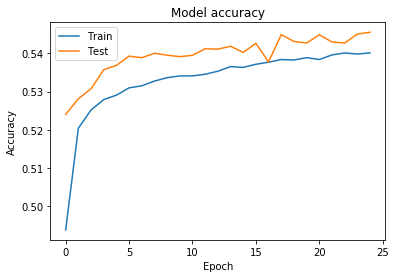

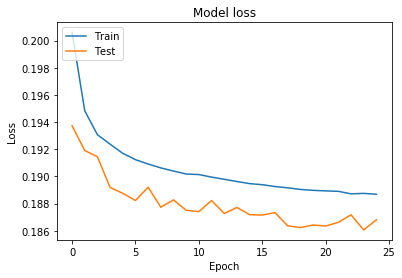

In [27]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [28]:
X_predict = model.predict(X_test)
#X_predict = X_predict.flatten()

In [29]:
#Y_test = Y_test.values
#test = Y_test.values
#test

In [30]:
#rounding the prediction in order to classify better, the model give us 0.99 for example but its close to 1, this is the reason
#the model give to us only a nearly 50% accuracy


#X_predict_round = np.around(X_predict, decimals=1)
#test = np.around(test, decimals=1)
#X_predict_round

In [31]:
X_predict_round = X_predict

for i in range(len(X_predict_round)):
    if X_predict_round[i][0] == X_predict[i].max():
        X_predict_round[i] = [1,0,0]
    elif X_predict_round[i][1] == X_predict[i].max():
        X_predict_round[i] = [0,1,0]
    elif X_predict_round[i][2] == X_predict[i].max():
        X_predict_round[i] = [0,0,1]
        
#X_predict_round = X_predict_round /100


In [32]:
#X_predict_round = X_predict*100

X_predict_round = X_predict_round.astype(int)
X_predict_round

array([[0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0]])

In [33]:
#to check how far we are from the required rounded output
model.evaluate(X_test,X_predict_round)



246353/246353 [==============================] - 7s 30us/step


[0.11423079142382507, 1.0]

In [34]:


accuracy = np.mean( X_predict_round == Y_test )

print('the final accuracy is: ' + str(accuracy*100) + '%')

the final accuracy is: 69.7853621970641%


In [35]:
#test
Y_test

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [36]:
Y_real = np.zeros(Y_test.shape[0])

for i in range(len(Y_test)):
    if np.array_equal(Y_test[i], [1,0,0]):
        Y_real[i] = 1
        
    elif np.array_equal(Y_test[i], [0,1,0]):
        Y_real[i] = 2
        
    else:
        Y_real[i] = 3
      

 

In [37]:
X_predicted = np.zeros(X_predict_round.shape[0])
    
    
for i in range(len(X_predict_round)):
    if np.array_equal(X_predict_round[i], [1,0,0]):
        X_predicted[i] = 1
        
    elif np.array_equal(X_predict_round[i], [0,1,0]):
        X_predicted[i] = 2
        
    else:
        X_predicted[i] = 3
      


[[22017 24665 35392]
 [ 8674 52908 20657]
 [ 7992 14272 59776]]


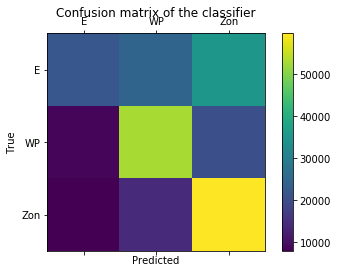

In [38]:
from sklearn.metrics import confusion_matrix

y_test = Y_real #* 10 #multiply to 10 to avoid the decimals (the confusion matrix get integers)

pred = X_predicted#*10 #multiply to 10 to avoid the decimals (the confusion matrix get integers)

labels = [1, 2,3] #the 3 labels we want to find (remember thereare the normalized data * 10)
cm = confusion_matrix(y_test, pred, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + ['E', 'WP', 'Zon'])
ax.set_yticklabels([''] + ['E', 'WP', 'Zon'])
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

print()

# Predicting people

In [39]:
#houses with:
#1 people: 4 9 
#2 people 
#3 people
#4 people
